In [2]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits import mplot3d
from collections import defaultdict
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import normaltest
from pandas.plotting import parallel_coordinates
from kneed import KneeLocator

In [3]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#PCA
from sklearn.decomposition import PCA
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [17]:
df=pd.read_csv("ravdess_features.csv")

In [18]:
df["emotion"]=df["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df["emotional_intensity"]=df["emotional_intensity"].replace(["normal", "strong"],[0,1])
df["vocal_channel"]=df["vocal_channel"].replace(["speech", "song"],[0,1])
df["repetition"]=df["repetition"].replace(["1st", "2nd"],[0,1])
df["sex"]=df["sex"].replace(["M", "F"],[0,1])
df["statement"]=df["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])

In [19]:
df["vocal_channel_fill"]=df["vocal_channel"]
df["vocal_channel_fill"]=df["vocal_channel_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mode()[0]))
df["intensity_fill"]=df["intensity"]
df["intensity_fill"]=df["intensity_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))
df["frame_count_fill"]=df["frame_count"]
df["frame_count_fill"]=df["frame_count_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))

## Statistiche generali

<AxesSubplot:xlabel='stft_min', ylabel='Density'>

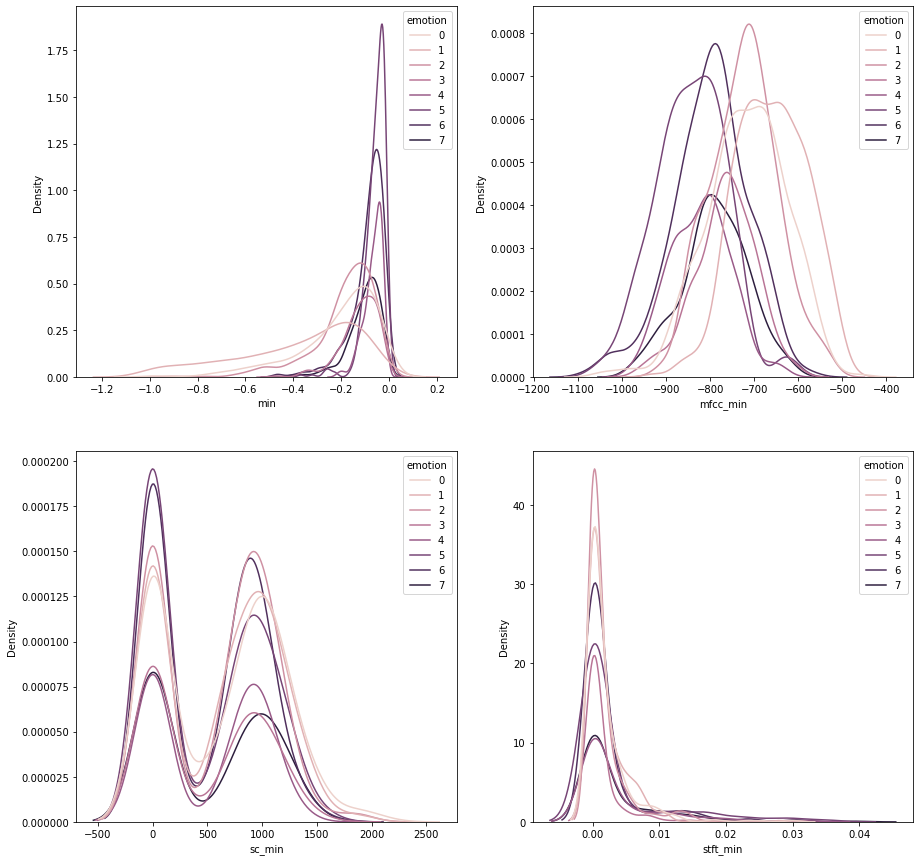

In [6]:
#min df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="min", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_min", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_min", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_min", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='intensity_fill', ylabel='Density'>

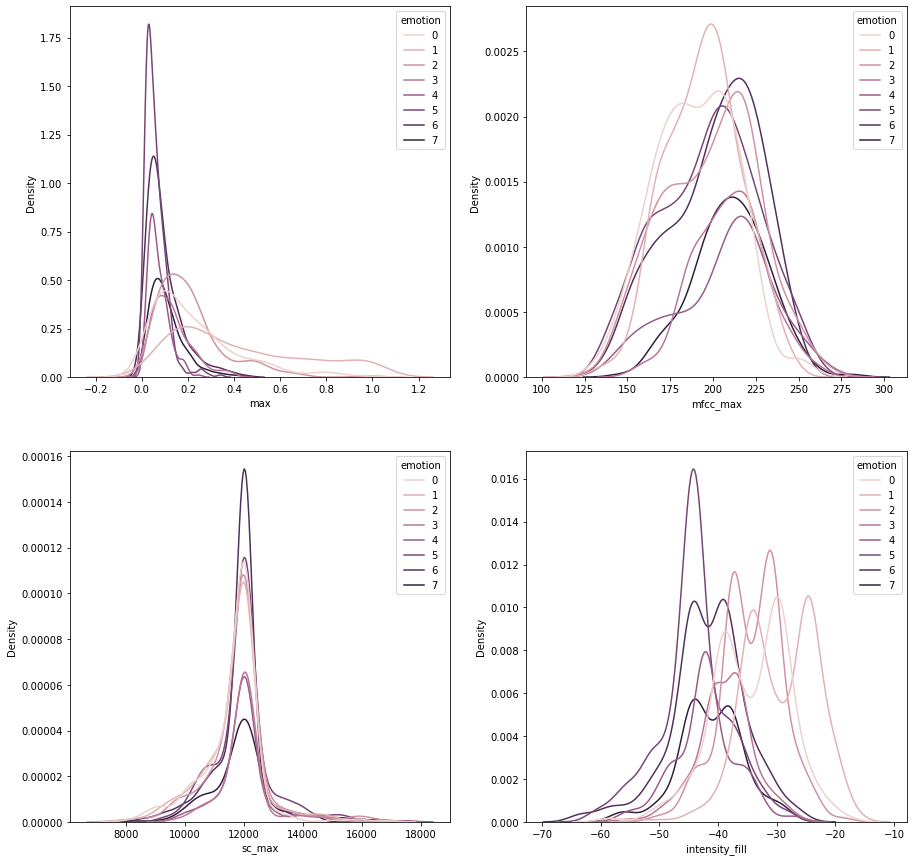

In [7]:
#max df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="max", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_max", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_max", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="intensity_fill", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_mean', ylabel='Density'>

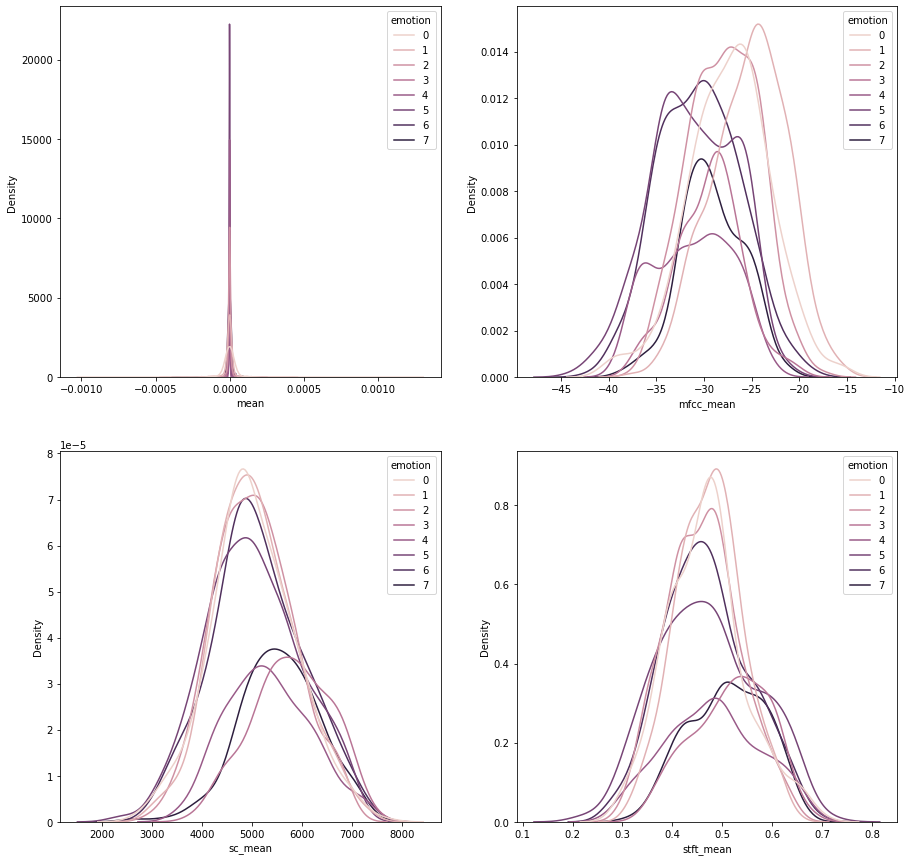

In [8]:
#mean df originale
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="mean", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_mean", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_mean", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_mean", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_std', ylabel='Density'>

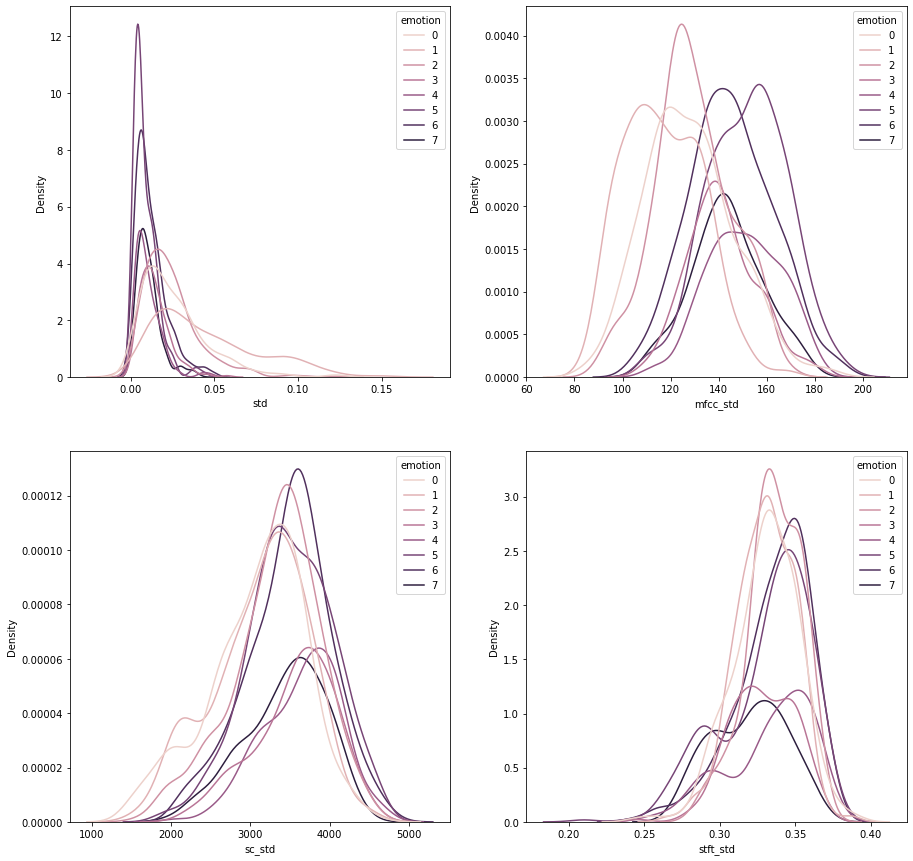

In [9]:
#std
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="std", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="mfcc_std", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_std", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_std", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_skew', ylabel='Density'>

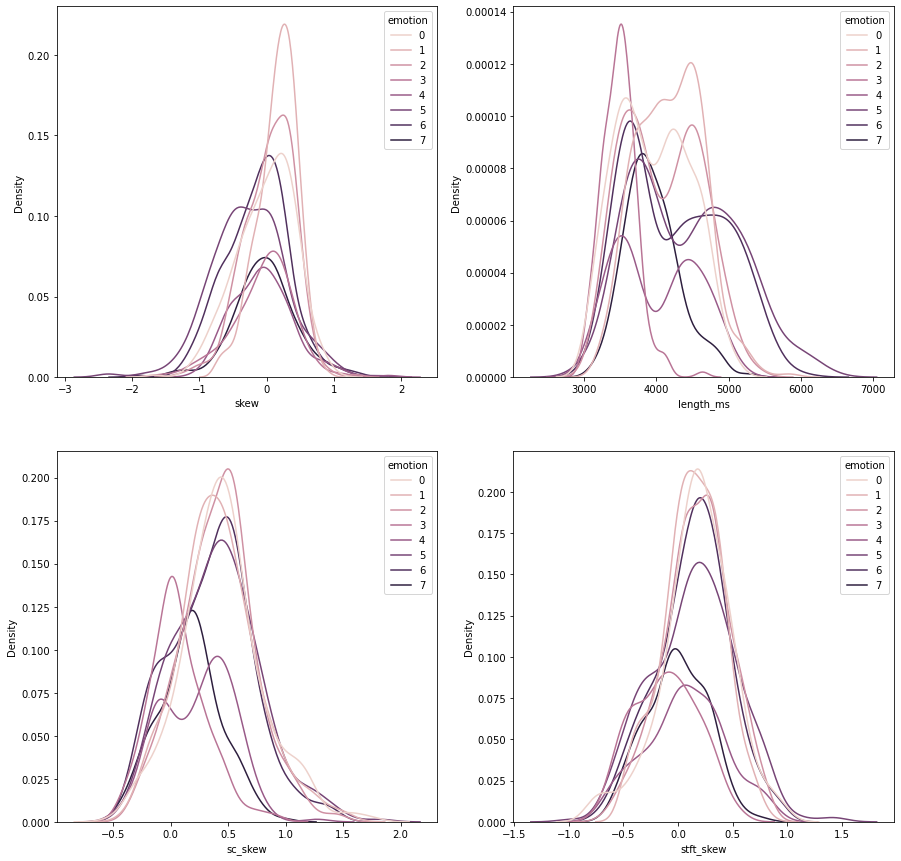

In [10]:
#skew and length
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="skew", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="length_ms", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_skew", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_skew", hue="emotion", ax=axs[1][1])

<AxesSubplot:xlabel='stft_kur', ylabel='Density'>

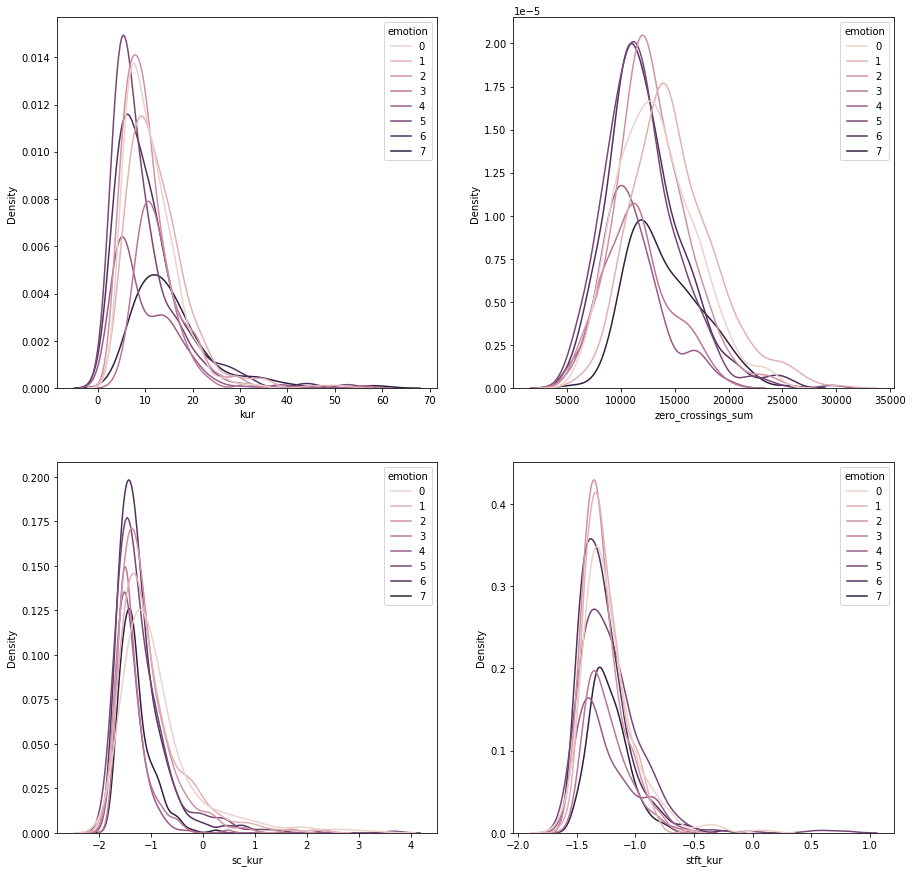

In [11]:
#zero-crossing-sum and kurtosis
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=df, x="kur", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=df, x="zero_crossings_sum", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=df, x="sc_kur", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=df, x="stft_kur", hue="emotion", ax=axs[1][1])

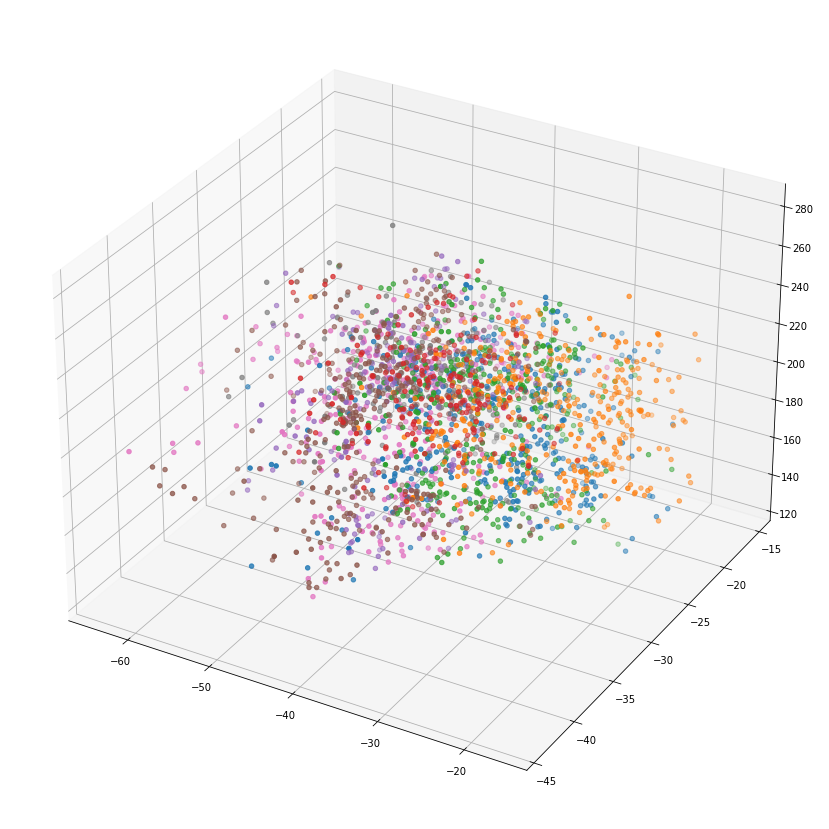

In [12]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in df.emotion.unique():
    ax.scatter(df.intensity_fill[df.emotion==s],df.mfcc_mean[df.emotion==s],df.mfcc_max[df.emotion==s],label=s)

## Outliers

In [13]:
#più interessanti
"""fig, axs = plt.subplots(5,2,figsize=(15,15))
sns.boxplot(data=df, x="mfcc_mean", y="emotion", ax=axs[0][0])
sns.boxplot(data=df, x="mfcc_std", y="emotion", ax=axs[0][1])
sns.boxplot(data=df, x="mfcc_min", y="emotion", ax=axs[1][0])
sns.boxplot(data=df, x="mfcc_max", y="emotion", ax=axs[1][1])
sns.boxplot(data=df, x="std", y="emotion", ax=axs[2][0])
sns.boxplot(data=df, x="min", y="emotion", ax=axs[2][1])
sns.boxplot(data=df, x="max", y="emotion", ax=axs[3][0])
sns.boxplot(data=df, x="length_ms", y="emotion", ax=axs[3][1])
sns.boxplot(data=df, x="intensity", y="emotion", ax=axs[4][0])
sns.boxplot(data=df, x="frame_count", y="emotion", ax=axs[4][1])"""

'fig, axs = plt.subplots(5,2,figsize=(15,15))\nsns.boxplot(data=df, x="mfcc_mean", y="emotion", ax=axs[0][0])\nsns.boxplot(data=df, x="mfcc_std", y="emotion", ax=axs[0][1])\nsns.boxplot(data=df, x="mfcc_min", y="emotion", ax=axs[1][0])\nsns.boxplot(data=df, x="mfcc_max", y="emotion", ax=axs[1][1])\nsns.boxplot(data=df, x="std", y="emotion", ax=axs[2][0])\nsns.boxplot(data=df, x="min", y="emotion", ax=axs[2][1])\nsns.boxplot(data=df, x="max", y="emotion", ax=axs[3][0])\nsns.boxplot(data=df, x="length_ms", y="emotion", ax=axs[3][1])\nsns.boxplot(data=df, x="intensity", y="emotion", ax=axs[4][0])\nsns.boxplot(data=df, x="frame_count", y="emotion", ax=axs[4][1])'

# Clustering

## Kmeans

In [20]:
#elimino le variabili non numeriche e inutili
df = df.drop(["emotion", "modality", "intensity", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex", "channels", "sample_width", "frame_rate", "frame_width", "sc_min", "stft_min", "stft_max", "vocal_channel_fill", "frame_count"], axis=1)

In [21]:
dfcopy1=df.copy()
dfcopy2=df
dfcopy3=df

In [22]:
df.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

In [23]:
#elimino le variabili altamente correlate (>|0.8| per df, >|0.95| per dfcopy2, >|0.7| per dfcopy3)
df = df.drop(["mfcc_std", "mfcc_min", "sc_mean", "stft_skew", "std", "min"],axis=1)
dfcopy2=dfcopy2.drop(["mfcc_std", "stft_skew", "std", "min"],axis=1)
dfcopy3 = dfcopy3.drop(["length_ms", "mfcc_std", "mfcc_min", "sc_mean", "stft_skew", "std", "min", "sc_kur", "stft_std", "intensity_fill"],axis=1)

In [24]:
dfcopy3.corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

In [25]:
X = df.values
X1 = dfcopy2.values
X2 = dfcopy3.values
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)
X_minmax1 = scaler.fit_transform(X1)
X_minmax2 = scaler.fit_transform(X2)

<AxesSubplot:ylabel='Count'>

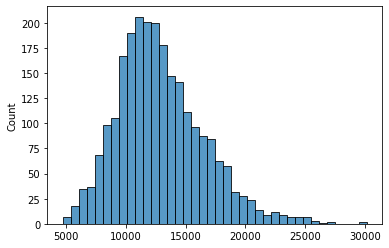

In [26]:
sns.histplot(data=X, x=X[:,1])

<AxesSubplot:ylabel='Count'>

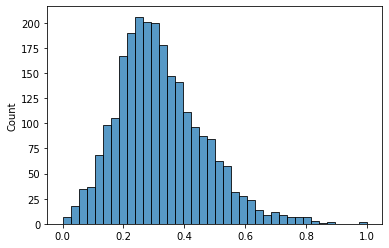

In [27]:
sns.histplot(data=X_minmax, x=X_minmax[:,1])

In [28]:
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=100)
kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=4)

<AxesSubplot:xlabel='intensity_fill', ylabel='mfcc_mean'>

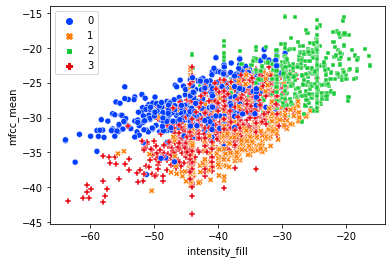

In [29]:
sns.scatterplot(data=df, x="intensity_fill", y="mfcc_mean", hue=kmeans.labels_, style=kmeans.labels_,
                palette="bright")

In [30]:
sse_list = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append(kmeans.inertia_)

In [31]:
sse_list1 = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax1)
    sse_list1.append(kmeans.inertia_)

In [32]:
sse_list2 = []
for k in range(1, 50):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax2)
    sse_list2.append(kmeans.inertia_)

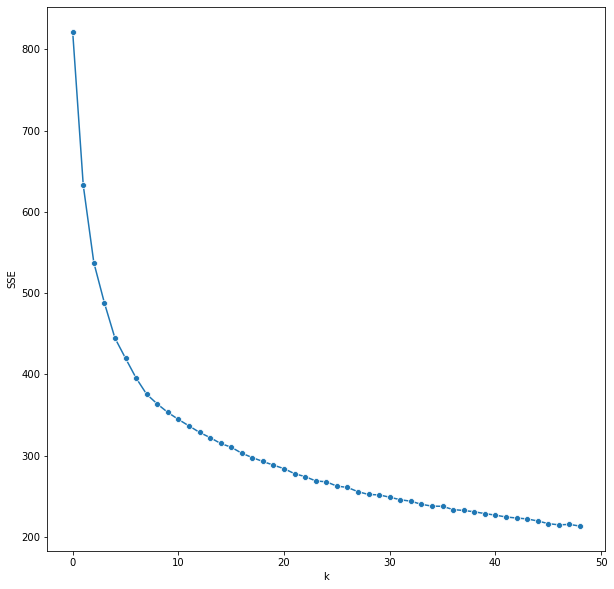

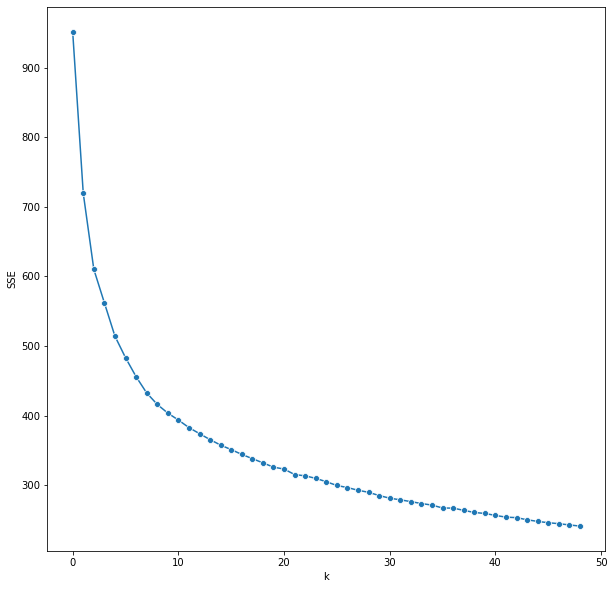

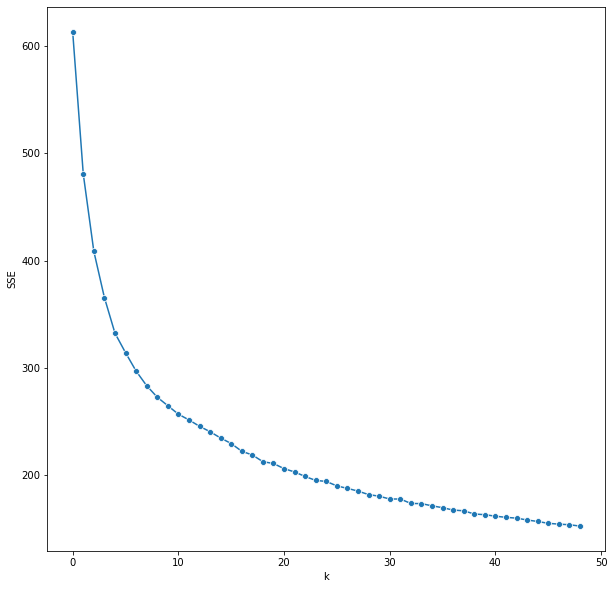

In [33]:
plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

plt.figure(figsize=(10,10))

sns.lineplot(x=range(len(sse_list1)), y=sse_list1, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(sse_list2)), y=sse_list2, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In [159]:
#knee locator
kn = KneeLocator(range(len(sse_list)), sse_list, curve='convex', direction='decreasing')
print(kn.knee)

kn1 = KneeLocator(range(len(sse_list1)), sse_list1, curve='convex', direction='decreasing')
print(kn1.knee)

kn2 = KneeLocator(range(len(sse_list2)), sse_list2, curve='convex', direction='decreasing')
print(kn2.knee)

7
8
8


In [160]:
kmeans = KMeans(init='k-means++', n_clusters=kn.knee, n_init=10, max_iter=100)
kmeans.fit(X_minmax)
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(X_minmax, kmeans.labels_))

kmeans1 = KMeans(init='k-means++', n_clusters=kn1.knee, n_init=10, max_iter=100)
kmeans1.fit(X_minmax1)
hist, bins = np.histogram(kmeans1.labels_, bins=range(0, len(set(kmeans1.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans1.inertia_)
print('silhouette', silhouette_score(X_minmax1, kmeans1.labels_))

kmeans2 = KMeans(init='k-means++', n_clusters=kn2.knee, n_init=10, max_iter=100)
kmeans2.fit(X_minmax2)
hist, bins = np.histogram(kmeans2.labels_, bins=range(0, len(set(kmeans2.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans2.inertia_)
print('silhouette', silhouette_score(X_minmax2, kmeans2.labels_))

labels {0: 371, 1: 413, 2: 184, 3: 482, 4: 233, 5: 380, 6: 389}
sse 395.5111067530993
silhouette 0.16994428570487935
labels {0: 189, 1: 436, 2: 351, 3: 148, 4: 350, 5: 299, 6: 337, 7: 342}
sse 432.64174898713867
silhouette 0.15976932115010833
labels {0: 144, 1: 297, 2: 315, 3: 445, 4: 314, 5: 208, 6: 407, 7: 322}
sse 283.24490151935936
silhouette 0.16201325580738843


In [36]:
df.head()

length_ms  zero_crossings_sum  mfcc_mean   mfcc_max       sc_std  \
0       3737               16995 -33.485947  171.69092  3328.055457   
1       3904               13906 -29.502108  205.00770  4040.931570   
2       4671               18723 -30.532463  165.45653  3332.131300   
3       3637               11617 -36.059555  190.03609  4053.663073   
4       4404               15137 -31.405996  161.13400  3442.724109   

         sc_max    sc_kur   sc_skew  stft_mean  stft_std  stft_kur  \
0  13541.959028 -1.120769  0.250940   0.415250  0.335533 -1.215025   
1  12000.290443 -1.531204  0.219582   0.417488  0.352380 -1.384174   
2  12007.751173 -1.130153  0.436699   0.379758  0.352270 -1.242947   
3  12048.223893 -1.497765  0.098802   0.407277  0.360552 -1.445318   
4  12025.582707 -1.167544  0.496066   0.415974  0.350655 -1.366742   

           mean       max        kur      skew  intensity_fill  \
0  3.844916e-07  0.138947   9.406061  0.273153      -36.793432   
1 -7.149491e-08  0.263062  19.564187  0.292157      -34.071849   
2  2.429985e-06  0.166351   4.881241  0.302659      -32.290737   
3  2.373929e-07  0.024078  13.040259 -0.081014      -49.019839   
4  8.454691e-07  0.242676   7.485109  0.414872      -31.214503   

   frame_count_fill  
0          179379.0  
1          187387.0  
2          224224.0  
3          174575.0  
4          211411.0

In [161]:
df["klabels"]=kmeans.labels_
dfcopy2["klabels"]=kmeans1.labels_
dfcopy3["klabels"]=kmeans2.labels_

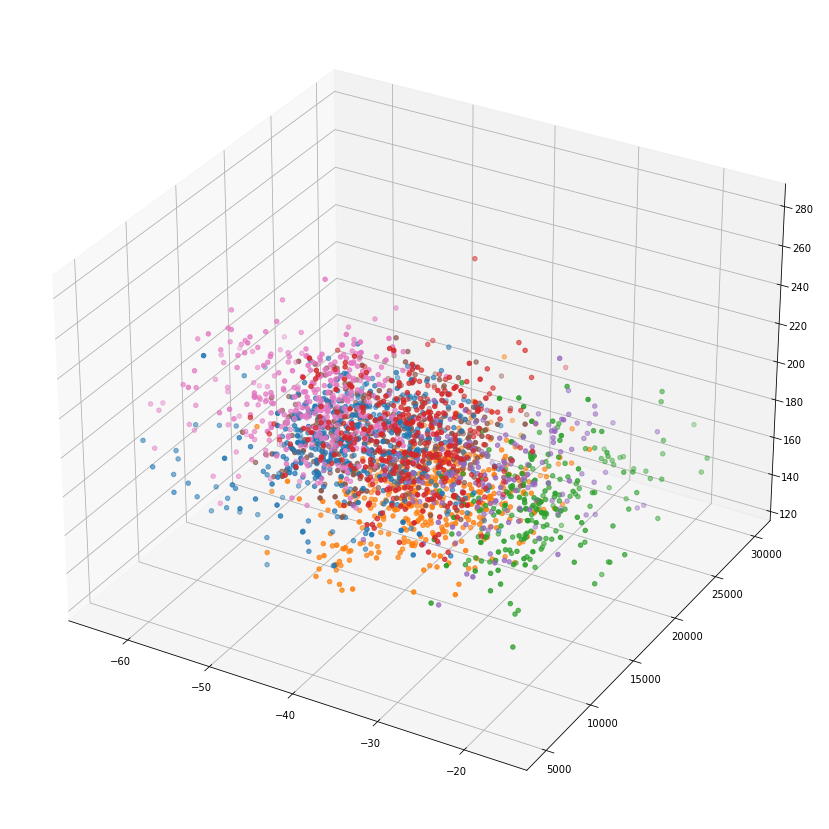

In [162]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in df.klabels.unique():
    ax.scatter(df.intensity_fill[df.klabels==s],df.zero_crossings_sum[df.klabels==s],df.mfcc_max[df.klabels==s],label=s)

<AxesSubplot:xlabel='intensity_fill', ylabel='mfcc_mean'>

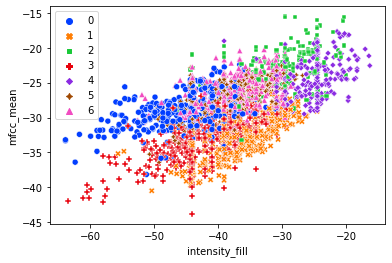

In [163]:
sns.scatterplot(data=df, x="intensity_fill", y="mfcc_mean", hue=kmeans.labels_, style=kmeans.labels_,
                palette="bright")

In [164]:
len(kmeans.cluster_centers_)

7

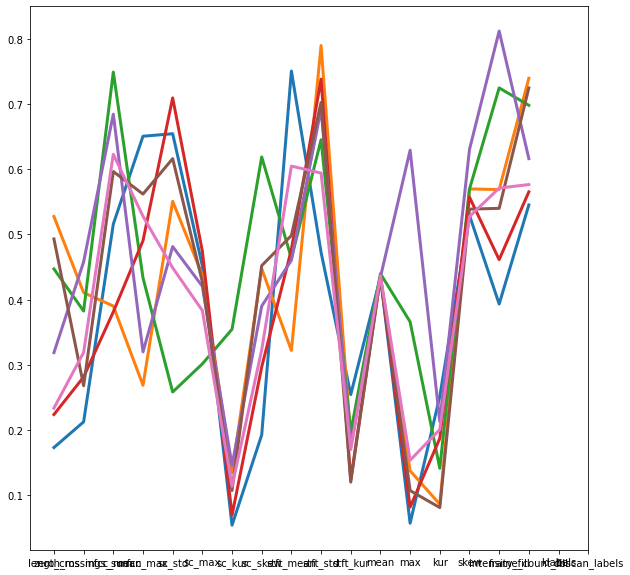

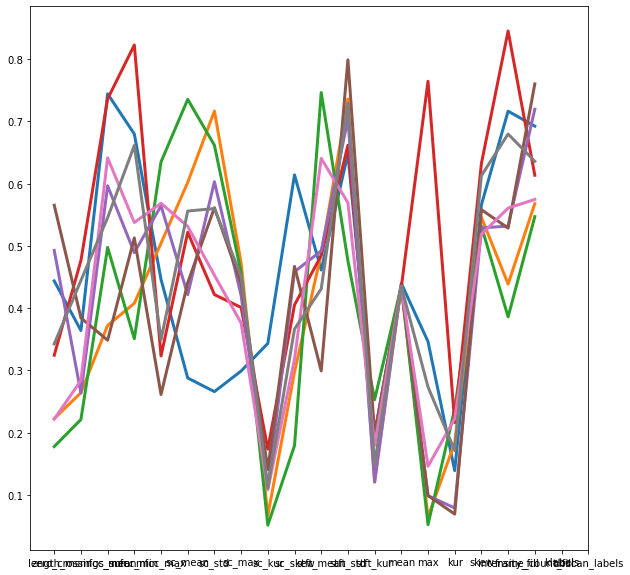

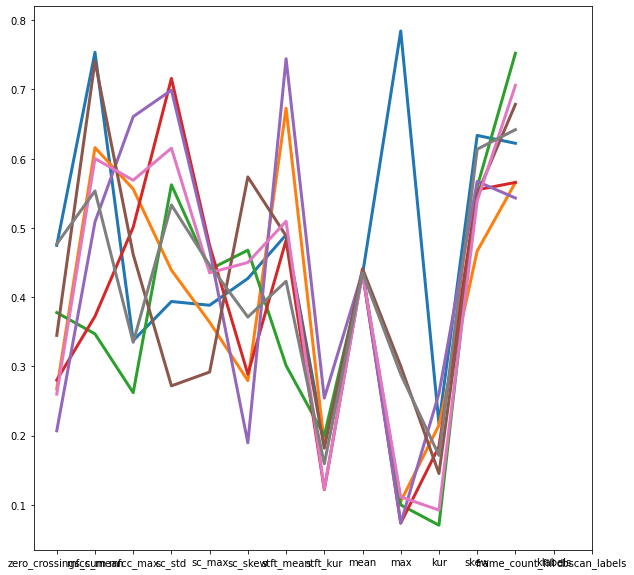

In [165]:
plt.figure(figsize=(10,10))
for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, len(kmeans.cluster_centers_[0])), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(df.columns)), list(df))
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(kmeans1.cluster_centers_)):
    plt.plot(range(0, len(kmeans1.cluster_centers_[0])), kmeans1.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(dfcopy2.columns)), list(dfcopy2))
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(kmeans2.cluster_centers_)):
    plt.plot(range(0, len(kmeans2.cluster_centers_[0])), kmeans2.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(len(dfcopy3.columns)), list(dfcopy3))
plt.show()

### PCA analysis

([<matplotlib.axis.XTick at 0x7f65789fe9a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

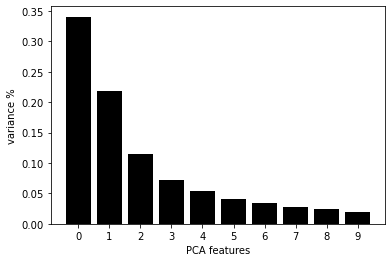

In [166]:
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X_minmax)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

([<matplotlib.axis.XTick at 0x7f658805f9a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

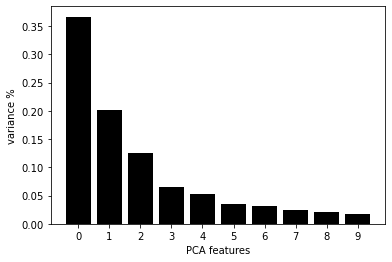

In [167]:
pca = PCA(n_components=10)
principal_components1 = pca.fit_transform(X_minmax1)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

([<matplotlib.axis.XTick at 0x7f6588036f10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

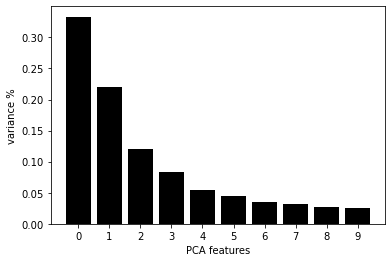

In [168]:
pca = PCA(n_components=10)
principal_components2 = pca.fit_transform(X_minmax2)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

2D PCA

In [169]:
pca = PCA(n_components=2)

principal_components = pca.fit_transform(X_minmax)
principal_components1 = pca.fit_transform(X_minmax1)
principal_components2 = pca.fit_transform(X_minmax2)

principal2dDf = pd.DataFrame(data = principal_components, columns = ["pc1", "pc2"])
principal2dDf1 = pd.DataFrame(data = principal_components1, columns = ["pc1", "pc2"])
principal2dDf2 = pd.DataFrame(data = principal_components2, columns = ["pc1", "pc2"])

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

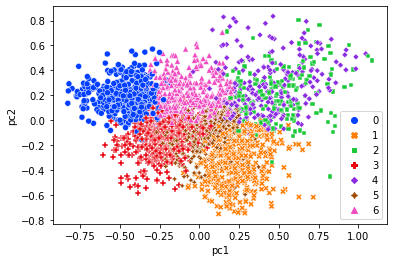

In [170]:
sns.scatterplot(data=principal2dDf, x="pc1", y="pc2", hue=kmeans.labels_, style=kmeans.labels_, palette="bright")

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

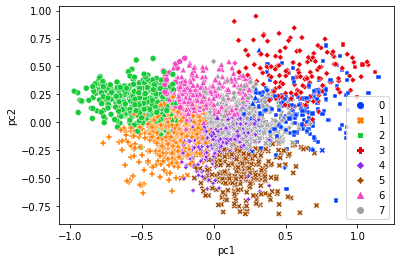

In [171]:
sns.scatterplot(data=principal2dDf1, x="pc1", y="pc2", hue=kmeans1.labels_, style=kmeans.labels_, palette="bright")

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

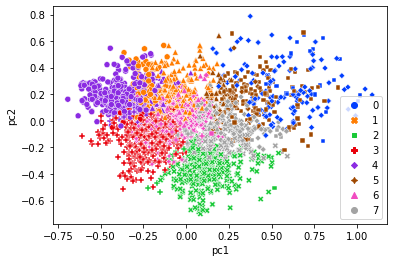

In [172]:
sns.scatterplot(data=principal2dDf2, x="pc1", y="pc2", hue=kmeans2.labels_, style=kmeans.labels_, palette="bright")

3D PCA

In [173]:
pca = PCA(n_components=3)

principal_components = pca.fit_transform(X_minmax)
principal_components1 = pca.fit_transform(X_minmax1)
principal_components2 = pca.fit_transform(X_minmax2)

principal3dDf = pd.DataFrame(data = principal_components, columns = ["pc1", "pc2", "pc3"])
principal3dDf1 = pd.DataFrame(data = principal_components1, columns = ["pc1", "pc2", "pc3"])
principal3dDf2 = pd.DataFrame(data = principal_components2, columns = ["pc1", "pc2", "pc3"])

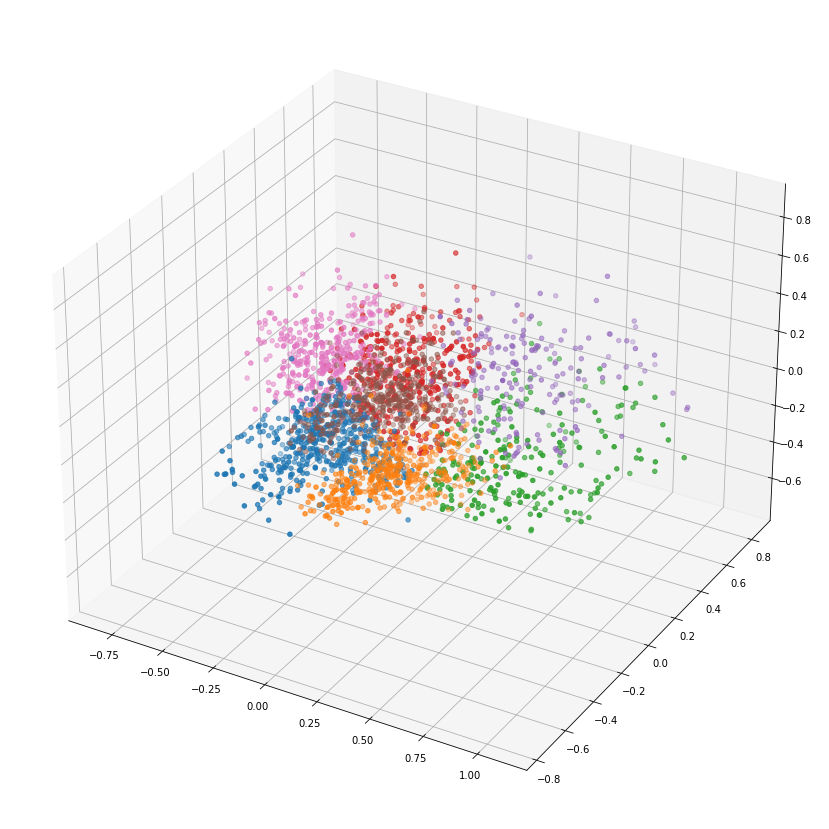

In [174]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in df.klabels.unique():
    ax.scatter(principal3dDf.pc1[df.klabels==s],principal3dDf.pc2[df.klabels==s],principal3dDf.pc3[df.klabels==s],label=s)

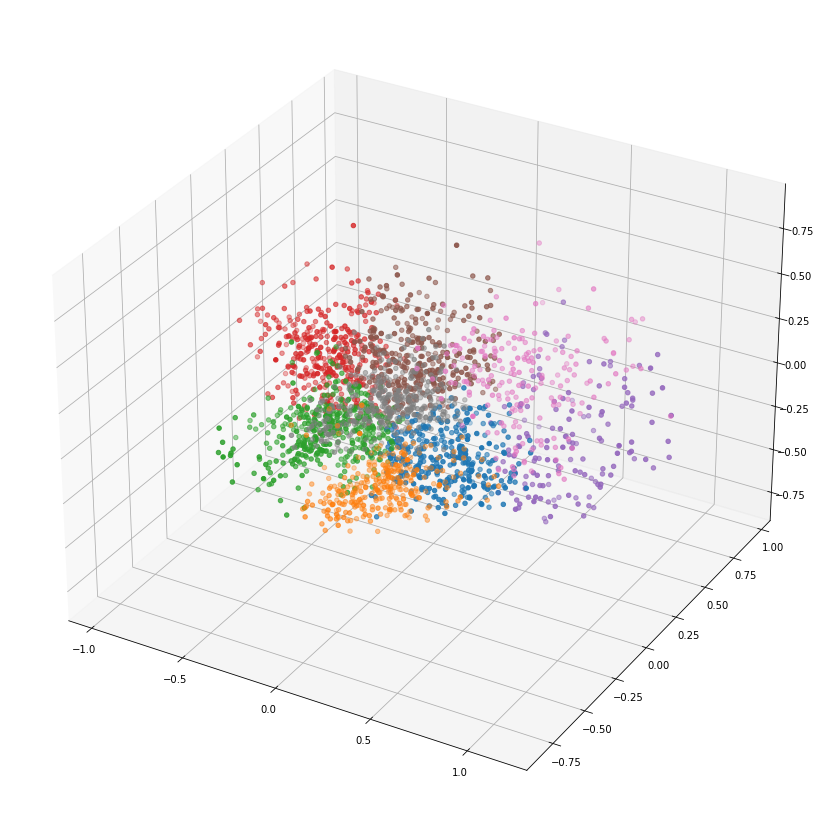

In [175]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in dfcopy2.klabels.unique():
    ax.scatter(principal3dDf1.pc1[dfcopy2.klabels==s],principal3dDf1.pc2[dfcopy2.klabels==s],principal3dDf1.pc3[dfcopy2.klabels==s],label=s)

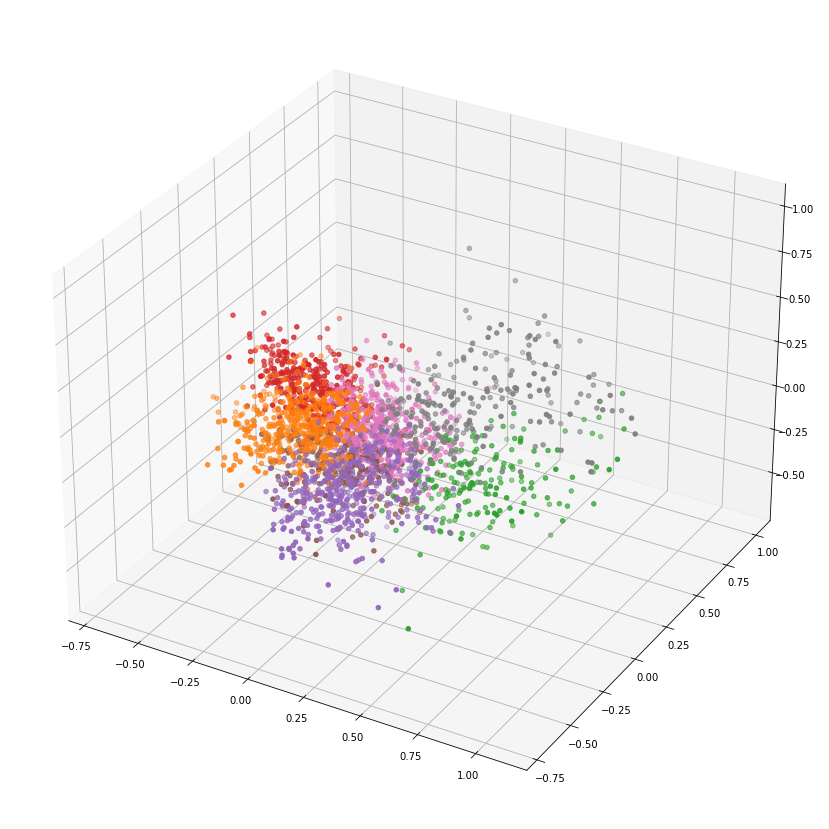

In [176]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in dfcopy3.klabels.unique():
    ax.scatter(principal3dDf2.pc1[df.klabels==s],principal3dDf2.pc2[df.klabels==s],principal3dDf2.pc3[df.klabels==s],label=s)

In [177]:
principal3dDf["klabels"]=kmeans.labels_
principal3dDf1["klabels"]=kmeans1.labels_
principal3dDf2["klabels"]=kmeans2.labels_

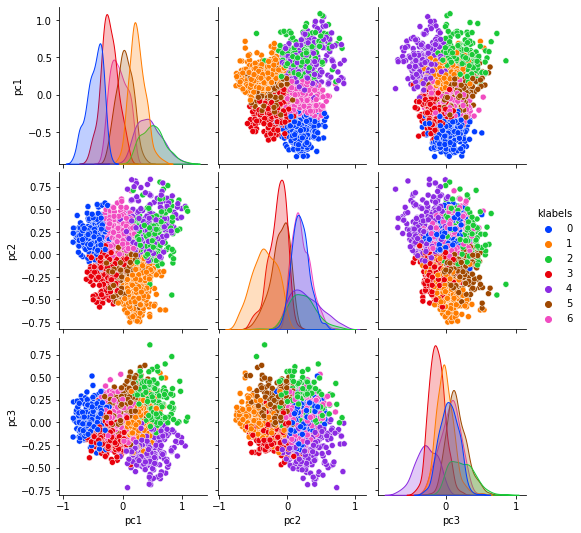

In [178]:
sns.pairplot(data=principal3dDf, hue="klabels", palette="bright")
plt.show()

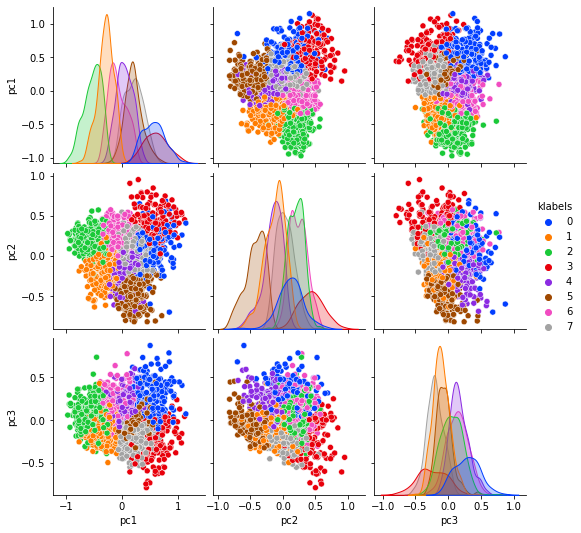

In [179]:
sns.pairplot(data=principal3dDf1, hue="klabels", palette="bright")
plt.show()

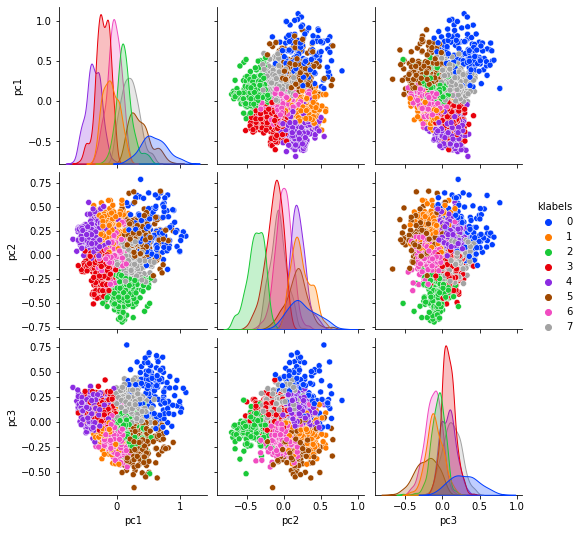

In [180]:
sns.pairplot(data=principal3dDf2, hue="klabels", palette="bright")
plt.show()

## DBScan

In [181]:
df.head()

length_ms  zero_crossings_sum  mfcc_mean   mfcc_max       sc_std  \
0       3737               16995 -33.485947  171.69092  3328.055457   
1       3904               13906 -29.502108  205.00770  4040.931570   
2       4671               18723 -30.532463  165.45653  3332.131300   
3       3637               11617 -36.059555  190.03609  4053.663073   
4       4404               15137 -31.405996  161.13400  3442.724109   

         sc_max    sc_kur   sc_skew  stft_mean  stft_std  stft_kur  \
0  13541.959028 -1.120769  0.250940   0.415250  0.335533 -1.215025   
1  12000.290443 -1.531204  0.219582   0.417488  0.352380 -1.384174   
2  12007.751173 -1.130153  0.436699   0.379758  0.352270 -1.242947   
3  12048.223893 -1.497765  0.098802   0.407277  0.360552 -1.445318   
4  12025.582707 -1.167544  0.496066   0.415974  0.350655 -1.366742   

           mean       max        kur      skew  intensity_fill  \
0  3.844916e-07  0.138947   9.406061  0.273153      -36.793432   
1 -7.149491e-08  0.263062  19.564187  0.292157      -34.071849   
2  2.429985e-06  0.166351   4.881241  0.302659      -32.290737   
3  2.373929e-07  0.024078  13.040259 -0.081014      -49.019839   
4  8.454691e-07  0.242676   7.485109  0.414872      -31.214503   

   frame_count_fill  klabels  dbscan_labels  
0          179379.0        3              0  
1          187387.0        3              0  
2          224224.0        1              0  
3          174575.0        3              0  
4          211411.0        1              0

In [182]:
dist = pdist(X_minmax, 'euclidean')
dist = squareform(dist)

dist1 = pdist(X_minmax1, 'euclidean')
dist1 = squareform(dist1)

dist2 = pdist(X_minmax2, 'euclidean')
dist2 = squareform(dist2)

In [183]:
k=5
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

kth_distances1 = []
for d in dist1:
    index_kth_distance = np.argsort(d)[k] 
    kth_distances1.append(d[index_kth_distance])  

kth_distances2 = []
for d in dist2: 
    index_kth_distance = np.argsort(d)[k]  
    kth_distances2.append(d[index_kth_distance]) 

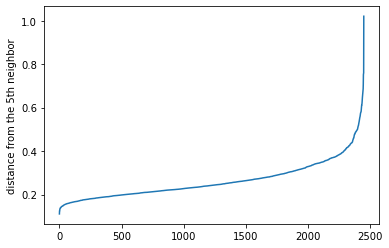

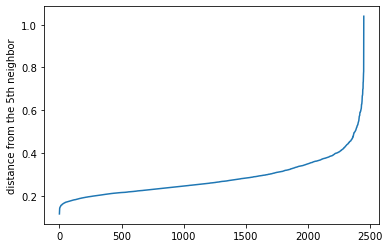

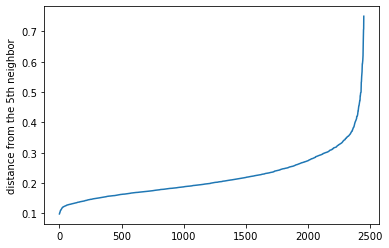

In [184]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

plt.plot(range(0, len(kth_distances1)), sorted(kth_distances1))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

plt.plot(range(0, len(kth_distances2)), sorted(kth_distances2))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.show()

In [185]:
#knee locator
kn = KneeLocator(range(len(kth_distances)), sorted(kth_distances), curve='convex', direction='increasing')
optimal_eps=np.interp(kn.knee, range(len(kth_distances)), sorted(kth_distances))
optimal_eps

0.47974271096137067

In [186]:
kn = KneeLocator(range(len(kth_distances1)), sorted(kth_distances1), curve='convex', direction='increasing')
optimal_eps1=np.interp(kn.knee, range(len(kth_distances1)), sorted(kth_distances1))
optimal_eps1

0.4955921253532071

In [187]:
kn = KneeLocator(range(len(kth_distances2)), sorted(kth_distances2), curve='convex', direction='increasing')
optimal_eps2=np.interp(kn.knee, range(len(kth_distances2)), sorted(kth_distances2))
optimal_eps2

0.41945287018225974

In [188]:
dbscan = DBSCAN(eps=optimal_eps, min_samples=4)
dbscan.fit(X_minmax)

dbscan1 = DBSCAN(eps=optimal_eps1, min_samples=4)
dbscan1.fit(X_minmax1)

dbscan2 = DBSCAN(eps=optimal_eps2, min_samples=4)
dbscan2.fit(X_minmax2)

DBSCAN(eps=0.41945287018225974, min_samples=4)

In [189]:
values, counts = np.unique(dbscan.labels_, return_counts=True)
print(values)
print(counts)

[-1  0  1]
[  20 2408   24]


In [190]:
values, counts = np.unique(dbscan1.labels_, return_counts=True)
print(values)
print(counts)

[-1  0  1]
[  24 2407   21]


In [191]:
values, counts = np.unique(dbscan2.labels_, return_counts=True)
print(values)
print(counts)

[-1  0  1]
[  18 2410   24]


In [192]:
df["dbscan_labels"]=dbscan.labels_
dfcopy2["dbscan_labels"]=dbscan1.labels_
dfcopy3["dbscan_labels"]=dbscan2.labels_

In [207]:
sorted_df = df.sort_values(by="dbscan_labels")
sorted_df1 = dfcopy2.sort_values(by="dbscan_labels")
sorted_df2 = dfcopy3.sort_values(by="dbscan_labels")
sorted_df

length_ms  zero_crossings_sum  mfcc_mean   mfcc_max       sc_std  \
1400       3504                8349 -34.546097  184.16351  4254.335472   
2102       3437                8605 -36.383682  207.41885  3696.121989   
1797       3337                6427 -20.810501  201.45715  2354.869904   
131        3637                8699 -19.016048  205.54400  2597.781286   
1803       4504               14981 -32.663437  216.92221  3506.135094   
...         ...                 ...        ...        ...          ...   
1427       3537               13077 -29.124308  183.37820  3624.155925   
2245       4338               13251 -31.049019  191.87555  3491.013361   
2093       4838               15194 -25.177988  216.03824  3651.626451   
1238       4471               12683 -26.245222  194.41292  3883.486083   
458        3670               10126 -26.775284  236.60167  3450.770617   

            sc_max    sc_kur   sc_skew  stft_mean  stft_std  stft_kur  \
1400  12149.989594 -1.669048 -0.172439   0.562563  0.340681 -1.268324   
2102  12079.288790 -1.207742 -0.365248   0.648529  0.266053 -0.246777   
1797  10808.879804 -0.853370  0.451838   0.650883  0.298777 -0.826186   
131   10115.531454 -0.984631  0.412383   0.677932  0.306066 -0.635036   
1803  12052.994776 -1.459735 -0.054749   0.664376  0.264430 -0.692043   
...            ...       ...       ...        ...       ...       ...   
1427  11925.628718 -1.245150  0.334428   0.359251  0.348048 -1.172609   
2245  12000.000156 -1.084673  0.488453   0.385101  0.359981 -1.377848   
2093  12037.004092 -1.245288  0.547716   0.428735  0.333195 -1.241205   
1238  12094.995554 -1.458286  0.466744   0.483000  0.338388 -1.448095   
458   12682.638371 -1.427613  0.143521   0.591118  0.293819 -1.159614   

              mean       max        kur      skew  intensity_fill  \
1400 -9.186051e-07  0.034760   6.504521 -0.437772      -40.995773   
2102  1.343066e-07  0.011932  55.833812 -0.455829      -62.350199   
1797 -9.435575e-04  0.291412  15.353364 -0.710158      -29.580034   
131  -9.024305e-05  0.854980  29.130588 -0.066459      -39.104762   
1803  1.323930e-07  0.010437  51.805768 -2.347655      -59.938720   
...            ...       ...        ...       ...             ...   
1427  1.517170e-07  0.377563  11.052940  0.380899      -28.391670   
2245 -2.865493e-06  0.144623   8.344269  0.189613      -36.225988   
2093  9.634972e-07  0.124054   2.508194  0.102335      -32.128582   
1238  2.539209e-06  0.125488   8.091365 -0.415216      -35.040439   
458   7.785121e-06  0.071503  23.811493 -0.858901      -44.069857   

      frame_count_fill  klabels  dbscan_labels  
1400              -1.0        3             -1  
2102          164964.0        0             -1  
1797          160160.0        6             -1  
131           174574.0        4             -1  
1803          216216.0        0             -1  
...                ...      ...            ...  
1427              -1.0        4              1  
2245              -1.0        3              1  
2093              -1.0        5              1  
1238              -1.0        3              1  
458               -1.0        0              1  

[2452 rows x 19 columns]

In [206]:
X_val=sorted_df.values
X_val1=sorted_df1.values
X_val2=sorted_df2.values

array([[ 3.5040000e+03,  8.3490000e+03, -3.4546097e+01, ...,
        -1.0000000e+00,  3.0000000e+00, -1.0000000e+00],
       [ 3.4370000e+03,  8.6050000e+03, -3.6383682e+01, ...,
         1.6496400e+05,  0.0000000e+00, -1.0000000e+00],
       [ 3.3370000e+03,  6.4270000e+03, -2.0810501e+01, ...,
         1.6016000e+05,  6.0000000e+00, -1.0000000e+00],
       ...,
       [ 4.8380000e+03,  1.5194000e+04, -2.5177988e+01, ...,
        -1.0000000e+00,  5.0000000e+00,  1.0000000e+00],
       [ 4.4710000e+03,  1.2683000e+04, -2.6245222e+01, ...,
        -1.0000000e+00,  3.0000000e+00,  1.0000000e+00],
       [ 3.6700000e+03,  1.0126000e+04, -2.6775284e+01, ...,
        -1.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [195]:
dist = pdist(X_val, 'euclidean')
dist = squareform(dist)

dist1 = pdist(X_val1, 'euclidean')
dist1 = squareform(dist1)

dist2 = pdist(X_val2, 'euclidean')
dist2 = squareform(dist2)

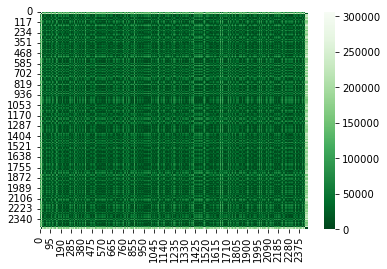

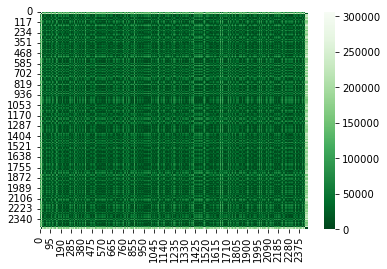

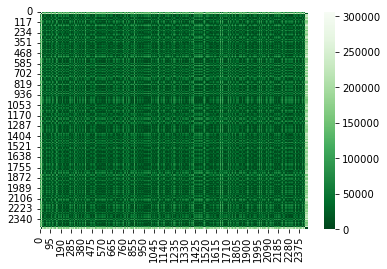

In [196]:
sns.heatmap(dist, cmap="Greens_r", annot=False)
plt.show()

sns.heatmap(dist, cmap="Greens_r", annot=False)
plt.show()

sns.heatmap(dist, cmap="Greens_r", annot=False)
plt.show()

## Hierarchical clustering

In [197]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Ward linkage

In [198]:
model_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model_ward = model_ward.fit(X_minmax)

model1_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model1_ward = model1_ward.fit(X_minmax1)

model2_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
model2_ward = model2_ward.fit(X_minmax2)

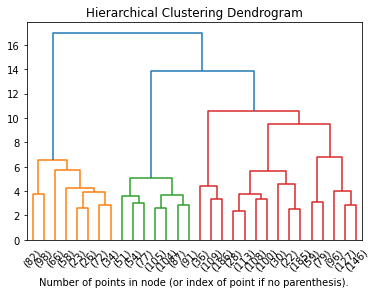

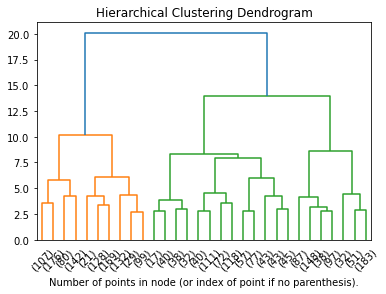

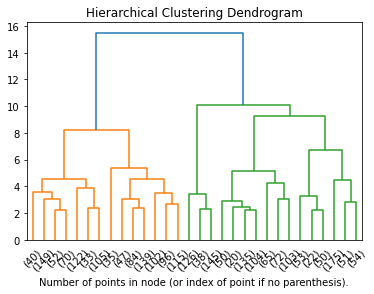

In [199]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_ward, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Average linkage

In [200]:
model_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model_avg = model_avg.fit(X_minmax)

model1_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model1_avg = model1_avg.fit(X_minmax1)

model2_avg = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='average')
model2_avg = model2_avg.fit(X_minmax2)

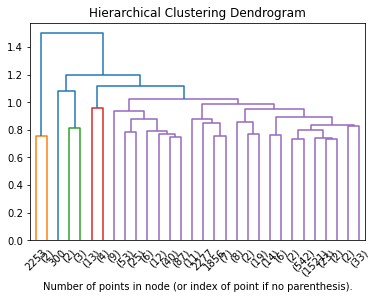

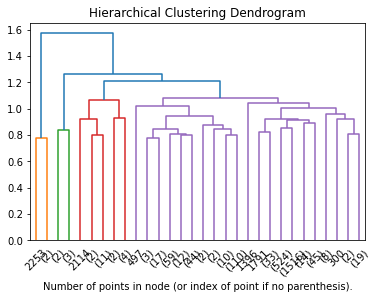

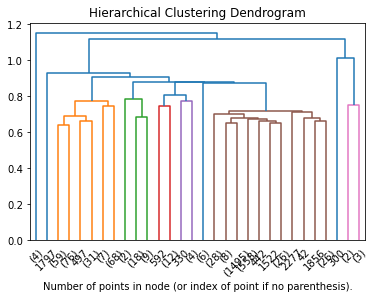

In [201]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Maximum linkage

In [202]:
model_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model_complete = model_complete.fit(X_minmax)

model1_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model1_complete = model1_complete.fit(X_minmax1)

model2_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='complete')
model2_complete = model2_complete.fit(X_minmax2)

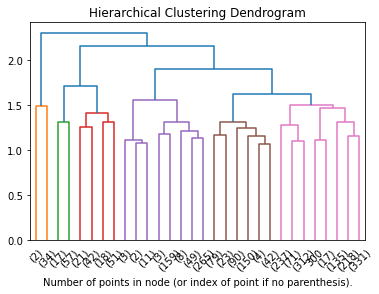

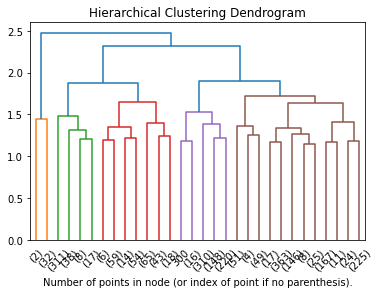

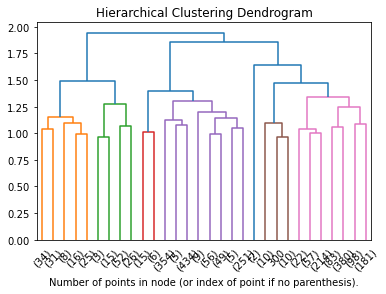

In [203]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Minimum

In [204]:
model_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model_single = model_single.fit(X_minmax)

model1_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model1_single = model1_single.fit(X_minmax1)

model2_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='single')
model2_single = model2_single.fit(X_minmax2)

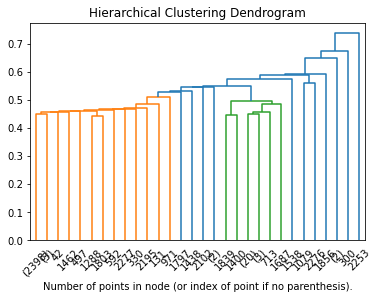

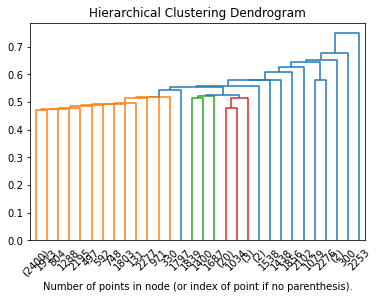

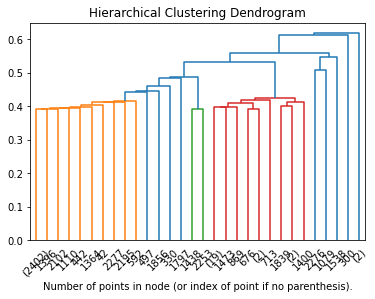

In [205]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model1_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model2_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()